# 卷积神经网络

输入、输出
卷积：不是对一个像素进行处理，而是对图片上的一小块区域进行

图片1（`长*宽*高(r+g+b)`）经过一次`卷积`得到新的图片，
图片2（`长/2 * 宽/2 * 高(r+g+b+一个新的特征)`）它的长宽信息减少，但在图片的深度上会增加，增加新的信息维度（例如边缘等）

在卷积的过程中可能会丢失一些信息，此时我们采用池化（Pooling）尽量不压缩长宽

常见结构（从下到上）：
   - image 图片
   - convolution 卷积
   - max pooling 池化
   - fully connected 全连接
   - fully connected 全连接
   - classifier 分类器

In [ ]:
# mnist手写识别

torch.Size([60000, 28, 28])
torch.Size([60000])


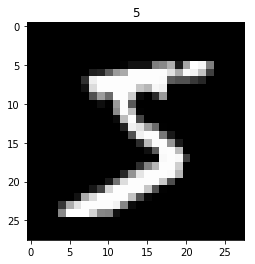

In [2]:
# coding:utf-8
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
torch: 0.1.11
torchvision
matplotlib
"""
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = False


# Mnist digits dataset
if not(os.path.exists('D:/0_PyData/mnist/')) or not os.listdir('D:/0_PyData/mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(
    root='D:/0_PyData/mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to将网上下载的图片转化为Tensor格式加载
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    # 归一化 (0-255) 到 (0,1)
    download=DOWNLOAD_MNIST,
)

# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [3]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 200 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='D:/0_PyData/mnist', train=False)

test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000].cuda()/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
# 上面除以255是为了归一化
test_y = test_data.test_labels[:2000].cuda()

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height 输入图片有几层（RGB 3层）
                out_channels=16,            # n_filters 16个filter在扫描，得到16层
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step 每隔stride步跳一下
                padding=2,                  # 图片边缘扩展的像素 if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            # 在conv的基础上再来一次filter max是去kernel中像素最大点
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # 参数同上卖弄那个conv output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes 数据集中要有10个分类

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)# (batch, 32, 7, 7)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output,x
                    # , x    # return x for visualization

In [10]:
cnn = CNN()
cnn.cuda()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [11]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

losses_his = []

In [12]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)


Epoch:  0 | train loss: 2.3067 | test accuracy: 0.00


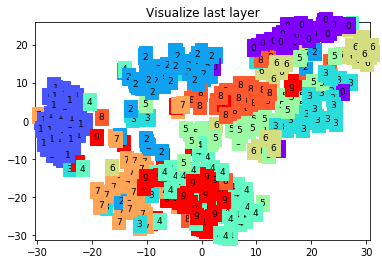

Epoch:  0 | train loss: 0.4701 | test accuracy: 0.00


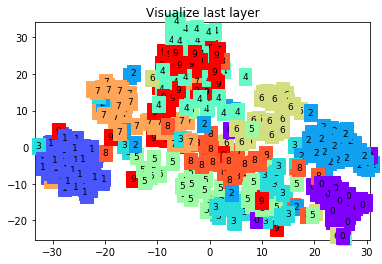

Epoch:  0 | train loss: 0.3220 | test accuracy: 0.00


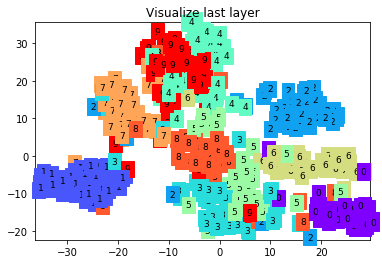

Epoch:  0 | train loss: 0.1997 | test accuracy: 0.00


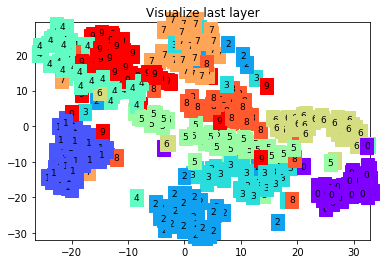

Epoch:  0 | train loss: 0.2480 | test accuracy: 0.00


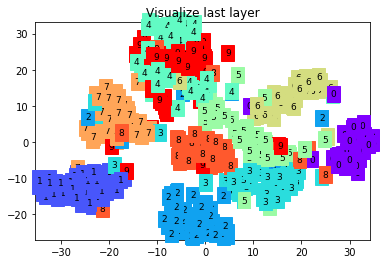

Epoch:  0 | train loss: 0.3634 | test accuracy: 0.00


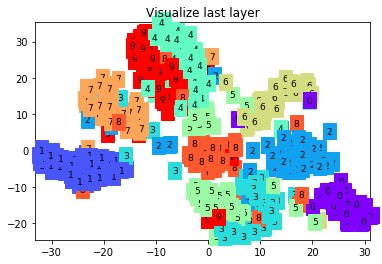

Epoch:  0 | train loss: 0.2314 | test accuracy: 0.00


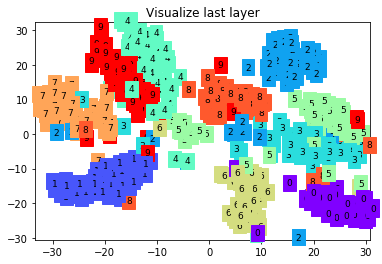

Epoch:  0 | train loss: 0.1069 | test accuracy: 0.00


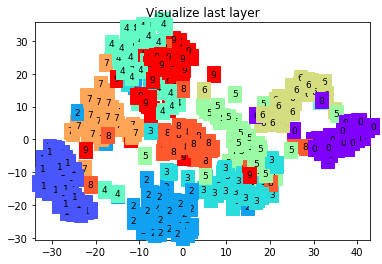

Epoch:  0 | train loss: 0.1034 | test accuracy: 0.00


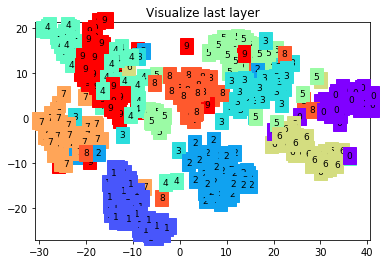

Epoch:  0 | train loss: 0.0962 | test accuracy: 0.00


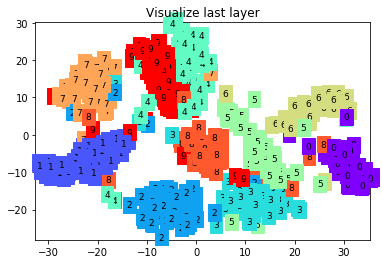

Epoch:  0 | train loss: 0.0193 | test accuracy: 0.00


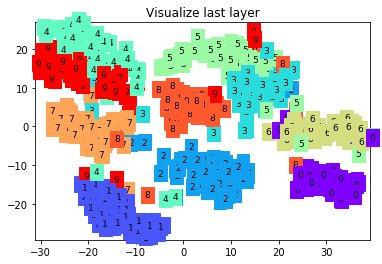

Epoch:  0 | train loss: 0.1223 | test accuracy: 0.00


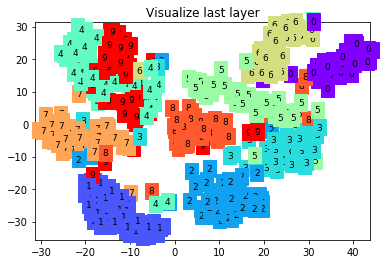

Epoch:  0 | train loss: 0.0680 | test accuracy: 0.00


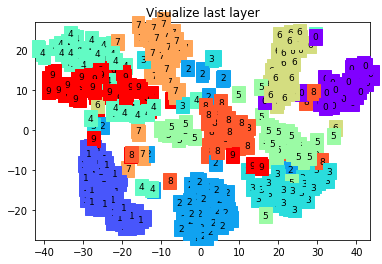

Epoch:  0 | train loss: 0.0970 | test accuracy: 0.00


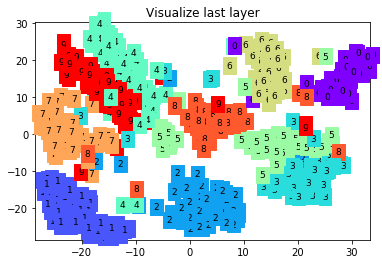

Epoch:  0 | train loss: 0.0437 | test accuracy: 0.00


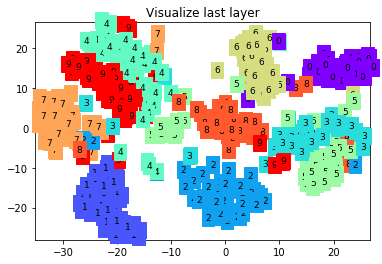

Epoch:  0 | train loss: 0.0688 | test accuracy: 0.00


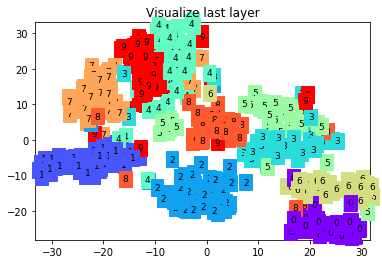

Epoch:  0 | train loss: 0.0408 | test accuracy: 0.00


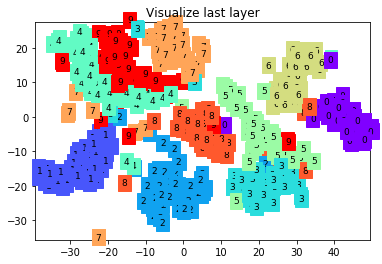

Epoch:  0 | train loss: 0.0868 | test accuracy: 0.00


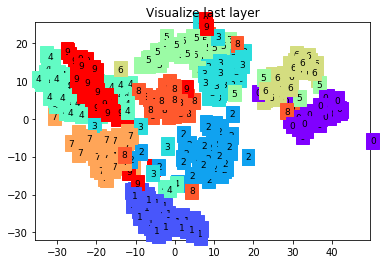

Epoch:  0 | train loss: 0.0371 | test accuracy: 0.00


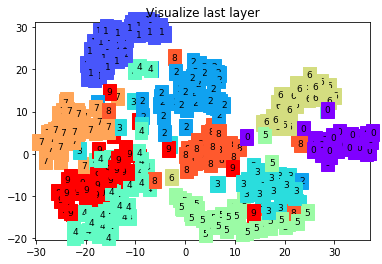

Epoch:  0 | train loss: 0.0092 | test accuracy: 0.00


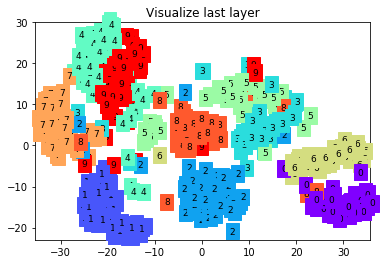

Epoch:  0 | train loss: 0.0243 | test accuracy: 0.00


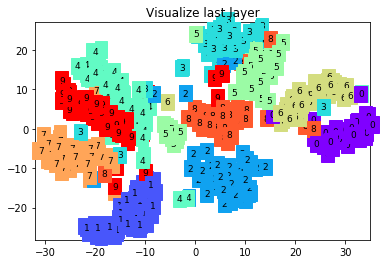

Epoch:  0 | train loss: 0.0336 | test accuracy: 0.00


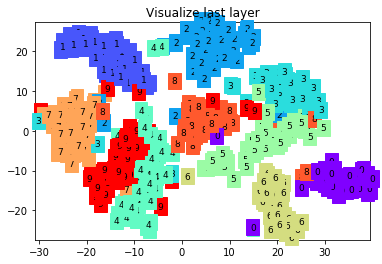

Epoch:  0 | train loss: 0.1492 | test accuracy: 0.00


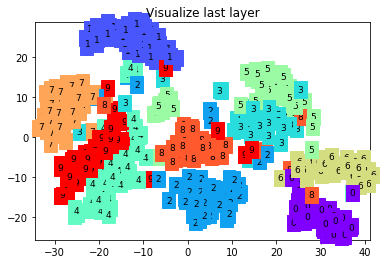

Epoch:  0 | train loss: 0.0396 | test accuracy: 0.00


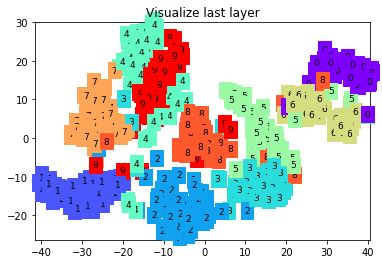

In [16]:
plt.ion()

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x).cuda()   # batch x
        b_y = Variable(y).cuda()   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        losses_his.append(loss.item())
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output,last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            accuracy = torch.sum(pred_y == test_y) / test_y.size(0)# sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.cpu().data.numpy()[:plot_only, :])
                labels = test_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
                
plt.ioff()

In [20]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].cpu().data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10].cpu().numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [1]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
torch: 0.1.11
torchvision
"""
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

# torch.manual_seed(1)

EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = False

train_data = torchvision.datasets.MNIST(root='D:/0_PyData/mnist/', train=True, transform=torchvision.transforms.ToTensor(), download=DOWNLOAD_MNIST,)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.MNIST(root='D:/0_PyData/mnist/', train=False)

# !!!!!!!! Change in here !!!!!!!!! #
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000].cuda()/255.   # Tensor on GPU
test_y = test_data.test_labels[:2000].cuda()


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2,),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2),)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2),)
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

cnn = CNN()

# !!!!!!!! Change in here !!!!!!!!! #
cnn.cuda()      # Moves all model parameters and buffers to the GPU.

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):

        # !!!!!!!! Change in here !!!!!!!!! #
        b_x = Variable(x).cuda()    # Tensor on GPU
        b_y = Variable(y).cuda()    # Tensor on GPU

        output = cnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            test_output = cnn(test_x)

            # !!!!!!!! Change in here !!!!!!!!! #
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()  # move the computation in GPU

            accuracy = torch.sum(pred_y == test_y) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)


test_output = cnn(test_x[:10])

# !!!!!!!! Change in here !!!!!!!!! #
pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze() # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:10], 'real number')


Epoch:  0 | train loss: 2.3205 | test accuracy: 0.00
Epoch:  0 | train loss: 0.5162 | test accuracy: 0.00
Epoch:  0 | train loss: 0.1080 | test accuracy: 0.00
Epoch:  0 | train loss: 0.1383 | test accuracy: 0.00
Epoch:  0 | train loss: 0.2388 | test accuracy: 0.00
Epoch:  0 | train loss: 0.3408 | test accuracy: 0.00
Epoch:  0 | train loss: 0.3952 | test accuracy: 0.00
Epoch:  0 | train loss: 0.2440 | test accuracy: 0.00
Epoch:  0 | train loss: 0.1101 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0738 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0878 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0904 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0369 | test accuracy: 0.00
Epoch:  0 | train loss: 0.2028 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0258 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0737 | test accuracy: 0.00
Epoch:  0 | train loss: 0.1078 | test accuracy: 0.00
Epoch:  0 | train loss: 0.0171 | test accuracy: 0.00
Epoch:  0 | train loss: 0.1816 | test accuracy

In [40]:
a = torch.linspace(1,16,16)
b = a.view(4,4)
print(b)
c = torch.max(b,1)
print(c)
d = c[1]
print(d)
e = d.data.squeeze()
print(e)

tensor([[  1.,   2.,   3.,   4.],
        [  5.,   6.,   7.,   8.],
        [  9.,  10.,  11.,  12.],
        [ 13.,  14.,  15.,  16.]])
(tensor([  4.,   8.,  12.,  16.]), tensor([ 3,  3,  3,  3]))
tensor([ 3,  3,  3,  3])
tensor([ 3,  3,  3,  3])


In [41]:
f = torch.clamp(b,8)
f

tensor([[  8.,   8.,   8.,   8.],
        [  8.,   8.,   8.,   8.],
        [  9.,  10.,  11.,  12.],
        [ 13.,  14.,  15.,  16.]])

In [43]:
g = sum(b == f)
h = float(b.size(0))

print(g)
print(h)

tensor([ 2,  2,  2,  3], dtype=torch.uint8)
4.0


In [44]:
hj = g/h
hj

tensor([ 0,  0,  0,  0], dtype=torch.uint8)

In [46]:
bj = torch.max(b, 1)
co = bj[1]
hg = co.data.squeeze()
print(bj,co,hg)

(tensor([  4.,   8.,  12.,  16.]), tensor([ 3,  3,  3,  3])) tensor([ 3,  3,  3,  3]) tensor([ 3,  3,  3,  3])
